In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Get Dataset

In [2]:
examples, metadata = tfds.load('cnn_dailymail', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2W9GPO/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2W9GPO/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2W9GPO/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


# Subword Tokenizer

In [3]:
# Build subword tokenizer
# Takes a lot of time
# tokenizer_summarize = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((art.numpy() for art, summ in train_examples), target_vocab_size=2**13)

In [5]:
# To save subword tokenizer in a file so that we don't need to build tokenizer from cropus always when we want to run the notebook.
# tokenizer_summarize.save_to_file('summarize')

# To load subword tokenizer from saved file
tokenizer_summarize = tfds.deprecated.text.SubwordTextEncoder.load_from_file('summarize')

## Encoding The Data

In [6]:
def encode(art, summ):
  art = [tokenizer_summarize.vocab_size] + tokenizer_summarize.encode(
      art.numpy()) + [tokenizer_summarize.vocab_size+1]

  summ = [tokenizer_summarize.vocab_size] + tokenizer_summarize.encode(
      summ.numpy()) + [tokenizer_summarize.vocab_size+1]

  return art, summ

In [7]:
BUFFER_SIZE = 20000
# BATCH_SIZE = 8 # As i don't have much resources so i picked batch_size as 8 you can pick batch_size = 64 if you have enough resources

In [8]:
def tf_encode(art, summ):
  result_art, result_summ = tf.py_function(encode, [art, summ], [tf.int64, tf.int64])
  result_art.set_shape([None])
  result_summ.set_shape([None])

  return result_art, result_summ

### Filter-out the dataset according to the length of dataset.

In [42]:
MAX_LENGTH = 1024 # As i don't have enough resources i picked max_length=1024 but you can pick max_length=2048 if you have enough resources

In [10]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [11]:
boundaries = [128, 256,  512, 1024]
batch_size = [16,    8,    4,    2, 1]

In [12]:
def _element_length_fn(x, y=None):
  return tf.shape(x)[0]

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.apply(tf.data.experimental.bucket_by_sequence_length(_element_length_fn, boundaries, batch_size,
                                                                                 drop_remainder=True))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.apply(tf.data.experimental.bucket_by_sequence_length(_element_length_fn, boundaries, batch_size,
                                                                                   drop_remainder=True))

In [14]:
art_batch, summ_batch = next(iter(val_dataset))
art_batch, summ_batch

(<tf.Tensor: shape=(2, 834), dtype=int64, numpy=
 array([[8116,   73,  767, ...,   83,  991, 8117],
        [8116,   73,  147, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(2, 200), dtype=int64, numpy=
 array([[8116, 6029,    5, 1405, 2287,    7, 1861, 2790, 1303, 6613,    8,
         1345,  257, 7251, 7892, 3177, 7892, 4638,  356, 7870, 4850, 7892,
          170, 1163, 7909, 7904,  168, 5851, 7892,    7, 2280,   11, 7103,
            9,  100,   90,  272,  356, 7870,  876, 1125,  241,  351,    4,
         1553,    9, 1314,    7, 1384, 6921, 7892,    8,  948, 6550,  356,
         8117,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,   

# Positional Encoding

In [15]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

  # apply sin to even indices in the array
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

In [17]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # add extra dimensions to add the padding to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

### look ahead masking

In [18]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Scaled Dot Product Attention

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """
  # multiply q and k
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Multi-Head Attention

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """
    Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

### Point wise feed forward network

In [21]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Transformer

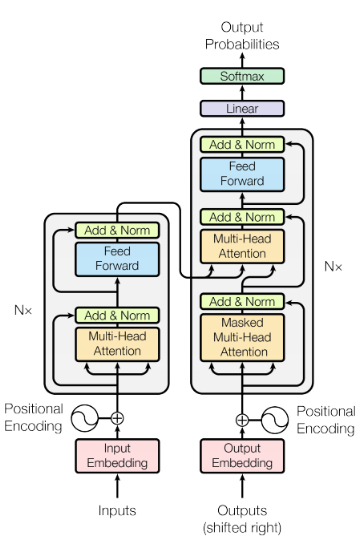

# Encoder Layer

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

# Decoder Layer

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

# Encoder

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

# Decoder

In [25]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Create The Transformer

In [26]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

### Hyperparameter and Optimizer

In [27]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8

vocab_size = tokenizer_summarize.vocab_size + 2
dropout_rate = 0.1

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [29]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Loss and metrics

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [31]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Training and Checkpoints

In [33]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          vocab_size, vocab_size, 
                          pe_input=vocab_size, 
                          pe_target=vocab_size,
                          rate=dropout_rate)

In [34]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [35]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [36]:
EPOCHS = 1 # For better training of the model set EPOCH = 20.

In [37]:
"""
The @tf.function trace-compiles train_step into a TF graph for faster
execution. The function specializes to the precise shape of the argument
tensors. To avoid re-tracing due to the variable sequence lengths or variable
batch sizes (the last batch is smaller), use input_signature to specify
more generic shapes.
"""

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [39]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> articles, tar -> summary
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    # For full training remove the 'if' statement typed below.
    # I am stopping this training as 1 epoch will take approx 6 hrs to complete and take many resources but i don't have many resources.
    if batch == 1300:
      ckpt_save_path = ckpt_manager.save()
      print('Saving checkpoint and stopping the training')
      break

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  

  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 7.2697 Accuracy 0.0432
Epoch 1 Batch 50 Loss 7.4746 Accuracy 0.0374
Epoch 1 Batch 100 Loss 7.4420 Accuracy 0.0398
Epoch 1 Batch 150 Loss 7.4460 Accuracy 0.0408
Epoch 1 Batch 200 Loss 7.4468 Accuracy 0.0410
Epoch 1 Batch 250 Loss 7.4532 Accuracy 0.0405
Epoch 1 Batch 300 Loss 7.4476 Accuracy 0.0407
Epoch 1 Batch 350 Loss 7.4344 Accuracy 0.0406
Epoch 1 Batch 400 Loss 7.4364 Accuracy 0.0412
Epoch 1 Batch 450 Loss 7.4365 Accuracy 0.0412
Epoch 1 Batch 500 Loss 7.4368 Accuracy 0.0414
Epoch 1 Batch 550 Loss 7.4352 Accuracy 0.0414
Epoch 1 Batch 600 Loss 7.4344 Accuracy 0.0414
Epoch 1 Batch 650 Loss 7.4320 Accuracy 0.0417
Epoch 1 Batch 700 Loss 7.4320 Accuracy 0.0419
Epoch 1 Batch 750 Loss 7.4307 Accuracy 0.0419
Epoch 1 Batch 800 Loss 7.4322 Accuracy 0.0422
Epoch 1 Batch 850 Loss 7.4326 Accuracy 0.0423
Epoch 1 Batch 900 Loss 7.4324 Accuracy 0.0425
Epoch 1 Batch 950 Loss 7.4339 Accuracy 0.0426
Epoch 1 Batch 1000 Loss 7.4335 Accuracy 0.0426
Epoch 1 Batch 1050 Loss 7.4330 Accur

# Evaluate

In [46]:
def evaluate(inp_sentence):
  start_token = [tokenizer_summarize.vocab_size]
  end_token = [tokenizer_summarize.vocab_size + 1]

  # inp sentence is article, hence adding the start and end token
  inp_sentence = start_token + tokenizer_summarize.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # as the target is summary, the first word to the transformer should be the summary start token.
  decoder_input = [tokenizer_summarize.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_summarize.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [49]:
def translate(sentence):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_summarize.decode([i for i in result 
                                            if i < tokenizer_summarize.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

In [50]:
# I twill output random text as the model accuracy is 4 percent.
translate("It was a sunny day when I went to the market to buy some flowers. But I only found roses, not tulips.")

Input: It was a sunny day when I went to the market to buy some flowers. But I only found roses, not tulips.
Predicted translation:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .